# Imports & Constants

In [1]:
import pandas as pd
import os
from rdflib import Graph, Namespace
from collections import defaultdict
from tqdm.notebook import tqdm
import json

# Base data path
data_path = './data/input 2024-05-02'

# Function to join paths and create directories if they don't exist
def create_and_get_path(*args):
    path = os.path.join(*args)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    return path

# Input paths
STUDY_TTL_PATH = create_and_get_path(data_path, 'input', 'instances.ttl') # contains the actual study data
VIOLATION_REPORT_TTL_PATH = create_and_get_path(data_path, 'input', 'violations.ttl') # contains the shacl violation test case result
OMICS_MODEL_TTL_PATH = create_and_get_path(data_path, 'input', 'omics_model.ttl') # contains the ontology

# Output paths
VIOLATION_LIST_FILE = create_and_get_path(data_path, 'output', 'json', 'violation_list.json') # path to store the violation list
STUDY_CSV_FILE = create_and_get_path(data_path, 'output', 'csv', 'study.csv') # path to store the tabularized study csv file
OMICS_MODEL_UNION_VIOLATION_EXEMPLAR_TTL_PATH = create_and_get_path(data_path, 'output', 'ttl', 'omics_model_union_violation_exemplar.ttl') # contains the union of the ontology and the violation exemplars
EXEMPLAR_EDGE_COUNT_DICT_PATH = create_and_get_path(data_path, 'output', 'json', 'exemplar_edge_count_dict.json') # contains the nested dict of exemplar edge counts
FOCUS_NODE_EXEMPLAR_DICT_PATH = create_and_get_path(data_path, 'output', 'json', 'focus_node_exemplar_dict.json') # contains the dict of exemplars per focus node
EXEMPLAR_FOCUS_NODE_DICT_PATH = create_and_get_path(data_path, 'output', 'json', 'exemplar_focus_node_dict.json') # contains the dict of focus nodes per exemplar
VIOLATION_EXEMPLAR_DICT_PATH = create_and_get_path(data_path, 'output', 'json', 'violation_exemplar_dict.json') # contains the dict of exemplars and their counts per violation

# define prefixes and corresponding namespaces
prefixes = {
    "sh": "http://www.w3.org/ns/shacl#",
    "omics": "http://data.boehringer.com/ontology/omics#",
    "owl": "http://www.w3.org/2002/07/owl#",    
    "cns": "http://customnamespace.com/n#"
}

In [2]:
import rdflib

def create_backup(ttl_path):
    # Read the input file
    with open(ttl_path, 'r') as file:
        data = file.read()

    # Define backup file path
    backup_file_path = ttl_path + ".bak"

    # Ensure the output directory exists
    os.makedirs(os.path.dirname(ttl_path), exist_ok=True)

    # Store backup file if it doesn't exist
    if not os.path.exists(backup_file_path):
        with open(backup_file_path, 'w') as file:
            file.write(data)

def handle_already_ns_already_exists(duplicate_ns, prefixes, ns_dict, g, changes):
    for prefix, uri in prefixes.items():
        # Normalize URI by ensuring it ends consistently
        normalized_uri = uri.rstrip('#/')
        for existing_prefix, existing_uri in ns_dict.items():
            # Check for existing URI prefix with different naming
            if existing_uri.rstrip('#/') == normalized_uri:
                # Rename all usages of the existing prefix in the graph
                namespace = rdflib.Namespace(uri)
                for s, p, o in g.triples((None, None, None)):
                    new_s = rename_if_matches(s, existing_uri, namespace)
                    new_p = rename_if_matches(p, existing_uri, namespace)
                    new_o = rename_if_matches(o, existing_uri, namespace)
                    if (s, p, o) != (new_s, new_p, new_o):
                        changes.append(((s, p, o), (new_s, new_p, new_o)))
                # Update the namespace manager to use the new prefix
                g.namespace_manager.bind(prefix, namespace, replace=True, override=True)

def rename_if_matches(node, existing_uri, namespace):
    if isinstance(node, rdflib.URIRef) and node.startswith(existing_uri):
        new_local_name = str(node).replace(existing_uri, '').lstrip('#/')
        return namespace[new_local_name]
    return node

def rebind_prefixes(g_path, prefixes):
    create_backup(g_path)
    g = rdflib.Graph()
    g.parse(g_path, format="turtle")

    ns_dict = {}
    for x in g.namespace_manager.namespaces():
        ns_dict[x[0]] = str(x[1])

    changes = []

    # Check if prefix or URI already exists in graph namespaces
    for prefix, uri in prefixes.items():
        if prefix in ns_dict and ns_dict[prefix] == uri:
            print(f"Prefix {prefix} with URI {uri} already correctly bound in the graph.")
            continue
        elif any(uri.rstrip('#/') == ns.rstrip('#/') for ns in ns_dict.values()):
            print(f"URI {uri} already exists in the graph under a different prefix. Adjusting...")
            handle_already_ns_already_exists(prefix, {prefix: uri}, ns_dict, g, changes)
        else:
            g.bind(prefix, rdflib.Namespace(uri))
            namespace = rdflib.Namespace(uri)

            # Prepare to change all URIs in the graph that start with the given URI
            for s, p, o in g.triples((None, None, None)):
                new_s = s if not isinstance(s, rdflib.URIRef) or not s.startswith(uri[:-1]) else namespace[str(s).split('/')[-1]]
                new_p = p if not isinstance(p, rdflib.URIRef) or not p.startswith(uri[:-1]) else namespace[str(p).split('/')[-1]]
                new_o = o if not isinstance(o, rdflib.URIRef) or not o.startswith(uri[:-1]) else namespace[str(o).split('/')[-1]]

                if (s, p, o) != (new_s, new_p, new_o):
                    changes.append(((s, p, o), (new_s, new_p, new_o)))

    # Apply changes
    for old_triple, new_triple in changes:
        g.remove(old_triple)
        g.add(new_triple)

    # Serialize and save the graph to a new Turtle file
    g.serialize(destination=g_path, format="turtle")



rebind_prefixes(STUDY_TTL_PATH, prefixes)
rebind_prefixes(VIOLATION_REPORT_TTL_PATH, prefixes)
rebind_prefixes(OMICS_MODEL_TTL_PATH, prefixes)

Prefix omics with URI http://data.boehringer.com/ontology/omics# already correctly bound in the graph.
Prefix owl with URI http://www.w3.org/2002/07/owl# already correctly bound in the graph.
Prefix sh with URI http://www.w3.org/ns/shacl# already correctly bound in the graph.
Prefix omics with URI http://data.boehringer.com/ontology/omics# already correctly bound in the graph.
Prefix owl with URI http://www.w3.org/2002/07/owl# already correctly bound in the graph.
Prefix sh with URI http://www.w3.org/ns/shacl# already correctly bound in the graph.
Prefix omics with URI http://data.boehringer.com/ontology/omics# already correctly bound in the graph.
Prefix owl with URI http://www.w3.org/2002/07/owl# already correctly bound in the graph.


# Give Enumerating Names to Unnamed Nodes
example:

[] a sh:ValidationResult -> <http://customnamespace.com/validationResult/1b29fdad-9eca-463f-b081-4e735785c238> a sh:ValidationResult

In [3]:
from rdflib import Graph, URIRef, BNode, Namespace
import uuid
import os
import re

def replace_with_incremented_name(match):
    class_name = match.group(1)
    return f"cns:{class_name}1"

def process_ttl_file(ttl_path):
    # Read the input file
    with open(ttl_path, 'r') as file:
        data = file.read()

    # Prepend '@prefix cns: <http://customnamespace.com/> .'
    data = "@prefix cns: <http://customnamespace.com/> .\n" + data
    
    # Apply textual replacements
    data = re.sub(r"\[\]\s+a\s+sh:(\w+)", replace_with_incremented_name, data)
    counter = 1
    while "[]" in data:
        data = data.replace("[]", f"cns:NodeShape{counter}", 1)
        counter += 1

    # Save the intermediate result to a temporary file
    intermediate_path = ttl_path + ".tmp"
    with open(intermediate_path, 'w') as file:
        file.write(data)

    # Load the intermediate Turtle file into RDFLib
    g = Graph()
    g.parse(ttl_path, format="ttl")

    # Define namespaces
    SH = Namespace("http://www.w3.org/ns/shacl#")
    g.bind("sh", SH)

    for s,p,o in g:
        print(s,p,o)

    # Generate and replace blank nodes
    unnamed_nodes = [node for node in g.all_nodes() if isinstance(node, BNode)]
    for bnode in unnamed_nodes:
        # Generate a new URI for the unnamed node using UUID
        new_uri = URIRef(f"http://customnamespace.com/validationResult/{uuid.uuid4()}")
        # Replace all occurrences of the blank node with the new URI in the graph
        for p, o in g.predicate_objects(subject=bnode):
            g.add((new_uri, p, o))
            g.remove((bnode, p, o))
        for s, p in g.subject_predicates(object=bnode):
            g.add((s, p, new_uri))
            g.remove((s, p, bnode))

    # Serialize the modified graph back to Turtle and overwrite the original file
    g.serialize(ttl_path, format="turtle")


    # Clean up: remove the intermediate file
    os.remove(intermediate_path)

# Process both files
process_ttl_file(OMICS_MODEL_TTL_PATH)
process_ttl_file(VIOLATION_REPORT_TTL_PATH)


http://data.boehringer.com/ontology/omics#TranscriptOmicsCalculatedResultShape-hasResultSpecies http://www.w3.org/ns/shacl#path http://data.boehringer.com/ontology/omics#hasResultSpecies
http://customnamespace.com/validationResult/ad9a8784-b457-455b-993d-ec2077e14e65 http://www.w3.org/ns/shacl#property http://data.boehringer.com/ontology/omics#a5e1e582-1066-4547-a579-578721c92839
http://data.boehringer.com/ontology/omics#hasSampleType http://www.w3.org/2000/01/rdf-schema#comment Description of the kind of the biological sample that has been used. These types fall into categories like, e.g. tissue or cellline. It is important to know the sample_type in order to decide whether e.g. the attributes cellline or cell need to be filled.
http://data.boehringer.com/ontology/omics#isFileOfResult http://www.w3.org/2000/01/rdf-schema#isDefinedBy http://data.boehringer.com/ontology/omics#
http://data.boehringer.com/ontology/omics#hasCellType http://www.w3.org/1999/02/22-rdf-syntax-ns#type http://ww

# Read & Parse Graphs

In [4]:
print("Reading study graph...")
study_g = Graph()
study_g.parse(STUDY_TTL_PATH, format="ttl")

print("Reading violations graph...")
violations_g = Graph()
violations_g.parse(VIOLATION_REPORT_TTL_PATH, format="ttl")

Reading study graph...
Reading violations graph...


<Graph identifier=Nf8bb98177dfc4e32b7bd2a8c07791837 (<class 'rdflib.graph.Graph'>)>

<span style="color:orange">Careful: If the omics_model.ttl contains [] anywhere else, e.g., in a label, it will also be replaced there!</span>

# Differentiate NaN Cases - Predicate cannot Exist on Class vs. Predicate is Missing vs. Predicate Exists Even Though It Cannot
A node can have an edge if

s1 a sh:NodeShape

s1 sh:targetClass node

s1 sh:property s2

s2 a sh:PropertyShape

s2 sh:Path edge

OR 

(
node rdfs:subClassOf s3
AND
s3 can have the edge
)

In [5]:
from rdflib import Graph
from rdflib.namespace import Namespace
import networkx as nx
import matplotlib.pyplot as plt

# read ontology into a graph
ontology_g = Graph()
ontology_g.parse(OMICS_MODEL_TTL_PATH, format="ttl")

# take namespace prefix for sh and omics from the graph
sh = Namespace("http://www.w3.org/ns/shacl#")
omics = Namespace("http://data.boehringer.com/ontology/omics#")
owl = Namespace("http://www.w3.org/2002/07/owl#")

# define prefixes and corresponding namespaces
prefixes = {
    "sh": "http://www.w3.org/ns/shacl#",
    "omics": "http://data.boehringer.com/ontology/omics#",
    "owl": "http://www.w3.org/2002/07/owl#"
}

def convert_to_prefixed(graph, uri):
    """Convert a URI to its prefixed form using a rdflib graph's namespace manager."""
    prefix, namespace, name = graph.namespace_manager.compute_qname(uri)
    return f"{prefix}:{name}"

def select_direct_possible_edges(node):
    select_statement = """
    SELECT ?edge
    WHERE {
        ?ns a sh:NodeShape .
        ?ns sh:targetClass %s .
        ?ns sh:property ?ps .
        ?ps a sh:PropertyShape .
        ?ps sh:path ?edge .
    }
    """ % node
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore

def select_direct_parents(node):
    select_statement = """
    SELECT ?parent
    WHERE {
        %s rdfs:subClassOf ?parent .
    }
    """ % node
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore

def select_direct_children(node):
    select_statement = """
    SELECT ?child
    WHERE {
        ?child rdfs:subClassOf %s .
    }
    """ % node
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore

def select_roots():
    select_statement = """
    SELECT ?root
    WHERE {
        ?root rdfs:subClassOf owl:Thing .
    }
    """
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore

def select_root_classes():
    select_statement = """
    SELECT ?class
    WHERE {
        ?class a owl:Class .
        FILTER NOT EXISTS { ?class rdfs:subClassOf ?parent . }
    }
    """
    return [str(result[0].n3(ontology_g.namespace_manager)) for result in ontology_g.query(select_statement)] # type: ignore


# use the functions
roots = select_root_classes()

In [6]:
class OntologyTree:
    def __init__(self):
        self.tree = {}

    def add_node(self, node, edges, children):
        if node not in self.tree:
            self.tree[node] = {'edges': edges, 'children': children}

    def add_child(self, parent, child):
        if parent in self.tree:
            self.tree[parent]['children'].append(child)
        else:
            self.tree[parent] = {'edges': [], 'children': [child]}

def aggregate_edges(node, tree):
    edges = set(tree[node]['edges'])
    queue = [parent_node for parent_node in tree if node in tree[parent_node]['children']]
    while queue:
        parent_node = queue.pop(0)
        edges |= set(tree[parent_node]['edges'])
        queue += [grand_parent for grand_parent in tree if parent_node in tree[grand_parent]['children']]
    return edges

def create_aggregated_edges_dict(tree):
    agg_edges_dict = {}
    for node in tree.keys():
        agg_edges_dict[node] = aggregate_edges(node, tree)
    return agg_edges_dict

def convert_to_full_uri(graph, abbreviated_uri):
    """Converts a prefixed URI to a full URI using a rdflib graph's namespace manager."""
    prefix, uri = abbreviated_uri.split(':')
    namespace = graph.namespace_manager.store.namespace(prefix)
    return namespace + uri

def remove_prefix(uri):
    if ':' in uri:
        return uri.split(':', 1)[1]
    return uri

def build_tree(root_nodes, ontology_tree):
    queue = root_nodes
    while queue:
        current_node = queue.pop(0)
        # unprefixed_node = remove_prefix(current_node)
        print('unprefixed_node', current_node)
        edges = select_direct_possible_edges(current_node)
        children = select_direct_children(current_node)

        ontology_tree.add_node(current_node, edges, children)

        for child in children:
            queue.append(child)


In [7]:
roots = select_root_classes()
ontology_tree = OntologyTree()
build_tree(roots, ontology_tree)
agg_edges_dict = create_aggregated_edges_dict(ontology_tree.tree)

unprefixed_node omics:Measurement
unprefixed_node omics:KeyValueHolder
unprefixed_node omics:Thing
unprefixed_node omics:ReferenceData
unprefixed_node omics:File
unprefixed_node omics:Treatment
unprefixed_node omics:Analysis
unprefixed_node omics:Contrast
unprefixed_node omics:Visit
unprefixed_node omics:Study
unprefixed_node omics:SampleSet
unprefixed_node omics:Donor
unprefixed_node omics:Sample
unprefixed_node omics:Result
unprefixed_node omics:Specimen
unprefixed_node omics:Condition
unprefixed_node omics:SequencingTechnology
unprefixed_node omics:Agent
unprefixed_node omics:Ethnicity
unprefixed_node omics:ExclusionReason
unprefixed_node omics:FileRead
unprefixed_node omics:Gender
unprefixed_node omics:HistologyType
unprefixed_node omics:LibraryPreparation
unprefixed_node omics:Platform
unprefixed_node omics:Project
unprefixed_node omics:ReadType
unprefixed_node omics:RouteOfAdministration
unprefixed_node omics:SamplePreparation
unprefixed_node omics:SampleType
unprefixed_node omic

In [8]:
def select_all_focus_nodes_and_classes(graph):
    select_statement = """
    SELECT ?node ?class
    WHERE {
        ?node a ?class .
    }
    """
    results = graph.query(select_statement)
    focus_nodes_classes_dict = {str(result[0]): str(result[1]) for result in results}
    return focus_nodes_classes_dict


focus_nodes_class_dict = select_all_focus_nodes_and_classes(study_g)

# Tabularize & Join Study + Violations Graphs

In [9]:
from rdflib import Graph, Namespace
from rdflib.namespace import NamespaceManager
from collections import defaultdict
import json
import pandas as pd
from tqdm import tqdm
empty_edge_string = "EdgeNotPresent"

SH = Namespace("http://www.w3.org/ns/shacl#")

def count_violations(violations: Graph):
    d_focus_node_d_source_shape_counts = defaultdict(lambda: defaultdict(int))
    d_violation_focus_node = defaultdict((str))
    d_violation_source_shape = defaultdict((str))
    violation_list = []

    for s, p, o in tqdm(violations, desc="Processing Graph Once"):
        if p == SH.sourceShape:
            d_violation_source_shape[str(s)] = str(o)
            violation_list += [str(o)]
        elif p == SH.focusNode:
            d_violation_focus_node[str(s)] = str(o)

    # for key in violation_focus_node dict
    for key in tqdm(d_violation_focus_node, desc="Going Over Violation Instances"):
        # init with 1 or add 1 if already exists
        d_focus_node_d_source_shape_counts[d_violation_focus_node[key]][d_violation_source_shape[key]] += 1

    violation_list = list(set(violation_list))
    return d_focus_node_d_source_shape_counts, violation_list


def save_violation_list(violation_list):
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)  


def create_study_dataframe(study: Graph, d_focus_node_d_source_shape_counts, focus_nodes_class_dict, agg_edges_dict):
    # for convenience
    pre = lambda x: convert_to_prefixed(ontology_g, str(x))

    # create an empty study_df, fill the violation counts
    study_df = pd.DataFrame(d_focus_node_d_source_shape_counts).T.fillna(0)

    count_not_skipped, count_skipped, count_allowed, count_not_allowed_exists, count_not_allowed_empty = 0, 0, 0, 0, 0

    # iterate all study triples
    for s, p, o in tqdm(study, desc="Processing study"):
        # if s is not in d_focus_node_d_source_shape_counts, continue as it is not a focus node
        if str(s) not in d_focus_node_d_source_shape_counts:
            count_skipped += 1
            continue
        count_not_skipped += 1

        # if p is not in study_df.columns, add it and set it to empty_edge_string for all rows because so far there has not been a value for it for anything, and future values will overwrite it anyway
        if str(p) not in study_df.columns:
            study_df[str(p)] = empty_edge_string

        # if object is empty throw exception and print details
        if str(o) == "":
            print("empty object for " + str(s) + " " + str(p))
            raise Exception("empty object for " + str(s) + " " + str(p))

        # get class of focus node
        focus_node_class = focus_nodes_class_dict.get(str(s), None)
        assert focus_node_class is not None, f"The focus_node_class for {str(s)} was None, but expected a value."
        # get allowed edges
        focus_node_edges = agg_edges_dict.get(convert_to_prefixed(ontology_g, focus_node_class), set())
        # assert len(focus_node_edges) > 0

        def write_object_to_study_df(study_df, s, p, o):
            current_value = study_df.at[str(s), str(p)]
            # Check if the current cell already contains a value that is not empty_edge_string
            if current_value == empty_edge_string:
                # If the cell is empty, directly assign the new value
                study_df.at[str(s), str(p)] = str(o)
            else:
                # If the cell already has a value, ensure it's a list and append the new value
                if not isinstance(current_value, list):
                    current_value = [current_value] if current_value != str(o) else current_value
                if isinstance(current_value, list):
                    current_value.append(str(o))
                # Update the DataFrame cell with the new value
                study_df.at[str(s), str(p)] = current_value


        # if edge is allowed (and object is present otherwise we wouldn't get here), set value study_df.at[str(s), str(p)] = str(o)
        if pre(p) in focus_node_edges:
            write_object_to_study_df(study_df, s, p, o)
            count_allowed += 1
        # if edge is not allowed, and there is no object, set value study_df.at[str(s), str(p)] = empty_edge_string
        elif pre(p) not in focus_node_edges and str(o) == "":
            study_df.at[str(s), str(p)] = empty_edge_string
            count_not_allowed_empty += 1
        # if edge is not allowed, and there is an object, set value study_df.at[str(s), str(p)] = "InvalidEdgeWUnexpectedEdgeWithDataithData: str(o)"
        elif pre(p) not in focus_node_edges and str(o) != "":
            # study_df.at[str(s), str(p)] = "UnexpectedEdgeWithData: " + str(o)
            write_object_to_study_df(study_df, s, p, o)
            count_not_allowed_exists += 1
        else:
            raise Exception("should not happen: " + str(s) + " " + str(p) + " " + str(o))

    print(f"count_skipped = {count_skipped}")
    print(f"count_not_skipped = {count_not_skipped}")
    print(f"count_allowed = {count_allowed}")
    print(f"count_not_allowed_exists = {count_not_allowed_exists}")
    print(f"count_not_allowed_empty = {count_not_allowed_empty}")

    assert study_df.isin(['']).sum().sum() == 0
    assert study_df.isnull().sum().sum() == 0, f"study_df.isnull().sum().sum() = {study_df.isnull().sum().sum()}"

    # add focus_node column, set it to the study_df.index, and move it to the very left of the dataframe
    study_df['focus_node'] = study_df.index
    cols = study_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]  # move the last column to the first
    study_df = study_df[cols]

    return study_df


def save_study_dataframe(study_df):
    study_df.to_csv(STUDY_CSV_FILE)

def replace_empty_edge_with_empty_array(df, empty_edge_string="EdgeNotPresent"):
    # Iterate through each column of the DataFrame
    for column in df.columns:
        # Determine if the column is a set column (contains at least one list)
        is_set_column = any(df[column].apply(lambda x: isinstance(x, list)))
        print(is_set_column, column)
        
        # Apply conditional replacement based on whether the column is a set column
        if is_set_column:
            # For set columns, replace empty_edge_string with an empty list
            df[column] = df[column].apply(lambda x: [] if x == empty_edge_string else x)
        else:
            # For non-set columns, ensure that empty_edge_string remains for missing values
            # This else block might not perform any action, but it's included for clarity.
            # Adjust or remove based on your specific requirements or if further logic is needed.
            pass
    return df

def post_process_convert_to_arrays(df, empty_edge_string="EdgeNotPresent"):
    for column in df.columns:
        # Check if any cell in the column contains a list
        contains_list = df[column].apply(lambda x: isinstance(x, list)).any()
        if contains_list:
            # Convert all non-list cells in the column into a list
            df[column] = df[column].apply(lambda x: [x] if not isinstance(x, list) else x)
        else:
            # For columns without lists, no action is needed
            pass
    return df

# Function to wrap single elements into arrays
def wrap_in_array(element):
    if not isinstance(element, list):
        return [element]
    return element


def tabularize_graphs(study: Graph, violations: Graph):
    print('study graph triples:', len(study))  # type: ignore
    print('violations graph triples:', len(violations))  # type: ignore
    d_focus_node_d_source_shape_counts, violation_list = count_violations(violations)
    save_violation_list(violation_list)
    study_df = create_study_dataframe(study, d_focus_node_d_source_shape_counts, focus_nodes_class_dict, agg_edges_dict)
    study_df = post_process_convert_to_arrays(study_df, empty_edge_string)
    rdf_type_string = 'http://www.w3.org/1999/02/22-rdf-syntax-ns#type'
    # always turn rdf:type column into a set column filled with arrays
    study_df[rdf_type_string] = study_df[rdf_type_string].apply(wrap_in_array)

    # study_df = replace_empty_edge_with_empty_array(study_df, empty_edge_string)
    save_study_dataframe(study_df)
    return d_focus_node_d_source_shape_counts


d_focus_node_d_source_shape_counts = tabularize_graphs(study_g, violations_g)

study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()


study graph triples: 9055
violations graph triples: 10


Processing study: 100%|██████████| 9055/9055 [00:00<00:00, 451137.04it/s]

count_skipped = 9039
count_not_skipped = 16
count_allowed = 15
count_not_allowed_exists = 1
count_not_allowed_empty = 0


,focus_node,http://data.boehringer.com/ontology/omics#cjabt,http://data.boehringer.com/ontology/omics#name,http://data.boehringer.com/ontology/omics#isSequencedForTherapeuticArea,http://data.boehringer.com/ontology/omics#technicalStudyTitle,http://data.boehringer.com/ontology/omics#hasContactCompBio,http://data.boehringer.com/ontology/omics#isPartOfProject,http://data.boehringer.com/ontology/omics#hasResponsibleSite,http://www.w3.org/1999/02/22-rdf-syntax-ns#type,http://data.boehringer.com/ontology/omics#studyDescription,http://data.boehringer.com/ontology/omics#sourceId,http://data.boehringer.com/ontology/omics#isSequencedForIndication,http://data.boehringer.com/ontology/omics#hasContactScientist,http://data.boehringer.com/ontology/omics#id,http://data.boehringer.com/ontology/omics#hasContactTechnical,http://data.boehringer.com/ontology/omics#sequencingDate,http://data.boehringer.com/ontology/omics#isExcluded,http://data.boehringer.com/ontology/omics#hasStudyType
http://data.boehringer.com/uuid/Study/e16b954b-6086-4300-8085-e29facf61364,http://data.boehringer.com/uuid/Study/e16b954b...,1,GSE191328_IBD_Longitudinal,http://vocabulary.boehringer.com/TherapeuticAr...,Longitudinal multi-omics analysis identifies e...,http://vocabulary.boehringer.com/OMICS/0252b64...,http://data.boehringer.com/lov/project/1384,http://vocabulary.boehringer.com/OMICS/62cafbe...,['http://data.boehringer.com/ontology/omics#St...,"longitudinal, blood-based multi-omics study in...",GSE191328,http://vocabulary.boehringer.com/TherapeuticAr...,http://vocabulary.boehringer.com/OMICS/de75b44...,e16b954b-6086-4300-8085-e29facf61364,http://vocabulary.boehringer.com/OMICS/0252b64...,2022-09-24T00:00:00,False,http://vocabulary.boehringer.com/OMICS/23031ef...


# Unit Tests for Violation Counting

In [10]:
import unittest
from rdflib import Graph, Literal, Namespace, BNode, URIRef

SH = Namespace("http://www.w3.org/ns/shacl#")

class TestCountViolations(unittest.TestCase):
    def setUp(self):
        self.violations = Graph()

    def test_count_violations_node_with_multiple_and_node_with_double(self):
        self.focusNode1 = BNode()
        self.focusNode2 = BNode()
        self.sourceShape1 = Literal('shape1')
        self.sourceShape2 = Literal('shape2')
        self.violation1 = BNode()
        self.violation2 = BNode()
        self.violation3 = BNode()
        self.violation4 = BNode()

        # Add triples to the violations graph
        self.violations.add((self.violation1, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation1, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation2, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation2, SH.sourceShape, self.sourceShape2))

        self.violations.add((self.violation3, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation3, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation4, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation4, SH.sourceShape, self.sourceShape1))
        violation_counts, violation_list = count_violations(self.violations)
        expected_counts = {
            str(self.focusNode1): {str(self.sourceShape1): 2},
            str(self.focusNode2): {str(self.sourceShape2): 1, str(self.sourceShape1): 1}
        }
        expected_list = [str(self.sourceShape1), str(self.sourceShape2)] 
        
        self.assertEqual(violation_counts, expected_counts)
        self.assertEqual(set(violation_list), set(expected_list))  # Use set to ignore order

    def test_count_violations_basic(self):
        self.focusNode1 = BNode()
        self.focusNode2 = BNode()
        self.focusNode3 = BNode()
        self.sourceShape1 = Literal('shape1')
        self.sourceShape2 = Literal('shape2')
        self.sourceShape3 = Literal('shape3')
        self.violation1 = BNode()
        self.violation2 = BNode()
        self.violation3 = BNode()

        # Add triples to the violations graph
        self.violations.add((self.violation1, SH.focusNode, self.focusNode1))
        self.violations.add((self.violation1, SH.sourceShape, self.sourceShape1))

        self.violations.add((self.violation2, SH.focusNode, self.focusNode2))
        self.violations.add((self.violation2, SH.sourceShape, self.sourceShape2))

        self.violations.add((self.violation3, SH.focusNode, self.focusNode3))
        self.violations.add((self.violation3, SH.sourceShape, self.sourceShape3))

        violation_counts, violation_list = count_violations(self.violations)
        expected_counts = {
            str(self.focusNode1): {str(self.sourceShape1): 1},
            str(self.focusNode2): {str(self.sourceShape2): 1},
            str(self.focusNode3): {str(self.sourceShape3): 1}
        }
        expected_list = [str(self.sourceShape1), str(self.sourceShape2), str(self.sourceShape3)] 
        
        self.assertEqual(violation_counts, expected_counts)
        self.assertEqual(set(violation_list), set(expected_list))  # Use set to ignore order

suite = unittest.TestLoader().loadTestsFromTestCase(TestCountViolations)
unittest.TextTestRunner().run(suite)


Going Over Violation Instances: 100%|██████████| 4/4 [00:00<?, ?it/s]
.
----------------------------------------------------------------------
Ran 2 tests in 0.008s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Abbreviation using QNames

In [11]:
import pandas as pd
import ast
from rdflib import Graph
from rdflib.namespace import split_uri

def namespace_in_nsm(nsm, namespace):
    """
    Checks if a given namespace is in the provided NamespaceManager.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to check
    namespace (str): the namespace to look for in the NamespaceManager

    Returns:
    bool: True if the namespace is in the NamespaceManager, False otherwise
    """
    for prefix, ns in nsm.namespaces():
        if str(ns) == str(namespace):
            return True
    return False

def get_qname(nsm, uri):
    """
    Returns a QName for a given URI if its namespace is in the provided NamespaceManager.
    If the namespace isn't found in the NamespaceManager, it returns the original URI.

    Parameters:
    nsm (NamespaceManager): the NamespaceManager object to use
    uri (str): the URI to transform into a QName

    Returns:
    str: a QName if the namespace of the URI is in the NamespaceManager, the original URI otherwise
    """
    namespace, name = split_uri(uri)
    if namespace_in_nsm(nsm, namespace):
        try:
            prefix, _, _ = nsm.compute_qname(uri)
            return f"{prefix}:{name}"
        except Exception as e:
            return uri
    else:
        return uri
    
def abbreviate_cell_value(nsm, cell_value):
    """
    Attempts to abbreviate URIs in a cell that may contain a string representation
    of a list of URIs or a single URI. If abbreviation is not possible, the original
    cell value is returned.
    
    Parameters:
    nsm (NamespaceManager): The NamespaceManager to use for abbreviation.
    cell_value (str): The cell value to abbreviate.
    
    Returns:
    str: The abbreviated cell value if possible; otherwise, the original cell value.
    """
    try:
        # Attempt to evaluate the cell_value as a list or single URI
        uris = ast.literal_eval(cell_value)
        # Handle list of URIs
        if isinstance(uris, list):
            abbreviated_uris = [get_qname(nsm, uri) for uri in uris]
            return str(abbreviated_uris)
        else:
            # Handle a single URI
            return get_qname(nsm, uris)
    except:
        # If the above fails (either due to eval or not being a URI), return original
        try:
            # Attempt to directly abbreviate assuming it's a single URI
            return get_qname(nsm, cell_value)
        except:
            # If all else fails, return the cell value as is
            return cell_value


def abbreviate_using_namespaces(study_graph: Graph, violations_graph: Graph):
    """
    Replaces URIs in a DataFrame and a list of violations with QNames if their namespaces
    are found in two provided RDF graphs. Saves the updated DataFrame and the list back to disk.

    Parameters:
    study_graph (Graph): the first RDF graph to use for namespaces
    violations_graph (Graph): the second RDF graph to use for namespaces
    """

    # load violation_list
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_list = json.load(f)

    # read study_df tabularized data
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    # Create a new graph to combine namespaces
    combined_graph = Graph()

    # Get namespaces from both graphs and bind them to the combined graph
    for prefix, ns_uri in study_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    for prefix, ns_uri in violations_graph.namespace_manager.namespaces():
        combined_graph.namespace_manager.bind(prefix, ns_uri)

    # Now use the NamespaceManager of the combined graph
    nsm_combined = NamespaceManager(combined_graph)

    # Change column names
    for col in study_df.columns:
        try:
            study_df.rename(columns={col: get_qname(nsm_combined, col)}, inplace=True)
        except:
            pass

     # Change cell values to handle arrays in string form
    for col in study_df.columns:
        for idx in study_df.index:
            cell_value = study_df.loc[idx, col]
            # Check if the cell contains a string that needs abbreviation
            if isinstance(cell_value, str):
                study_df.loc[idx, col] = abbreviate_cell_value(nsm_combined, cell_value)

    # Change indices and cell values
    for col in study_df.columns:
        for idx in study_df.index:
            try:
                study_df.loc[idx, col] = get_qname(nsm_combined, study_df.loc[idx, col])
            except:
                pass

    # change index
    for idx in study_df.index:
        try:
            study_df.rename(index={idx: get_qname(nsm_combined, str(idx))}, inplace=True)
        except:
            pass

    # change violation_list
    for i in range(len(violation_list)):
        try:
            violation_list[i] = get_qname(nsm_combined, violation_list[i])
        except:
            pass

    # store tabular graph as csv
    study_df.to_csv(STUDY_CSV_FILE)    

    # store violation_list as json
    with open(VIOLATION_LIST_FILE, 'w') as f:
        json.dump(violation_list, f)

abbreviate_using_namespaces(study_g, violations_g)

In [12]:
with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_list = json.load(f)

print('unique violations ('+str(len(violation_list))+'):\n')
print('\n'.join([str(v) for v in violation_list]))

unique violations (1):

omics:cjabt


In [13]:
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
study_df.head()

,focus_node,omics:cjabt,omics:name,omics:isSequencedForTherapeuticArea,omics:technicalStudyTitle,omics:hasContactCompBio,omics:isPartOfProject,omics:hasResponsibleSite,rdf:type,omics:studyDescription,omics:sourceId,omics:isSequencedForIndication,omics:hasContactScientist,omics:id,omics:hasContactTechnical,omics:sequencingDate,omics:isExcluded,omics:hasStudyType
http://data.boehringer.com/uuid/Study/e16b954b-6086-4300-8085-e29facf61364,http://data.boehringer.com/uuid/Study/e16b954b...,1,GSE191328_IBD_Longitudinal,http://vocabulary.boehringer.com/TherapeuticAr...,Longitudinal multi-omics analysis identifies e...,http://vocabulary.boehringer.com/OMICS/0252b64...,http://data.boehringer.com/lov/project/1384,http://vocabulary.boehringer.com/OMICS/62cafbe...,['omics:Study'],"longitudinal, blood-based multi-omics study in...",GSE191328,http://vocabulary.boehringer.com/TherapeuticAr...,http://vocabulary.boehringer.com/OMICS/de75b44...,e16b954b-6086-4300-8085-e29facf61364,http://vocabulary.boehringer.com/OMICS/0252b64...,2022-09-24T00:00:00,False,http://vocabulary.boehringer.com/OMICS/23031ef...


# Compute Violation Embedding

Dataframe has only 1 row, skipping UMAP embedding.
UMAP embedding created and saved to ./data/input 2024-05-02\output\csv\study.csv


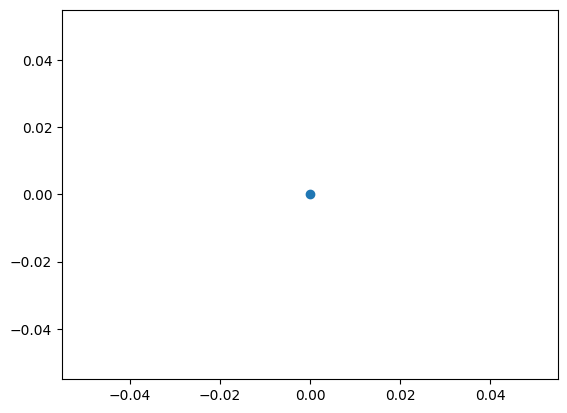

In [14]:
from matplotlib import pyplot as plt
import umap
import pandas as pd
import json
import numpy as np

from scipy.sparse import coo_matrix

def create_embedding():
    # read study.csv
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)
    
    # read violation_list.json
    with open(VIOLATION_LIST_FILE, 'r') as f:
        violation_columns = json.load(f)
    
    view_df = study_df[violation_columns]  # view of study dataframe with only violation columns

    if len(view_df) > 1:
        print("Creating UMAP embedding... (this may take some time)")
        reducer = umap.UMAP(n_neighbors=int(np.sqrt(len(view_df))), min_dist=0.1, n_components=2, random_state=0, verbose=True)
        result = reducer.fit_transform(view_df)  # 2D projection
    else:
        print("Dataframe has only 1 row, skipping UMAP embedding.")
        result = np.zeros((1, 2))  # Return a default embedding for the single data point

    # Check if the result is a tuple and unpack accordingly
    if isinstance(result, tuple):
        embedding, *_ = result
    else:
        embedding = result

    # Convert to dense numpy array if it's a sparse matrix
    if isinstance(embedding, coo_matrix):
        embedding = embedding.toarray()

    # Assuming that the embedding is now a NumPy array, based on the docstring
    study_df["x"] = embedding[:, 0]
    study_df["y"] = embedding[:, 1]

    study_df.to_csv(STUDY_CSV_FILE)
    print("UMAP embedding created and saved to", STUDY_CSV_FILE)


def plot_embedding():
    study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

    plt.scatter(study_df["x"], study_df["y"])
    plt.show()

create_embedding()
plot_embedding()


# Replace URIs with Label Data

In [15]:
import pandas as pd
import json
from rdflib import URIRef

# list of label predicates in ascending order of priority
label_predicates = [
    # URIRef('http://data.boehringer.com/ontology/omics/hasValue'),
    # URIRef('http://data.boehringer.com/ontology/omics/name'),
    URIRef('http://www.w3.org/2004/02/skos/core#prefLabel')
]

# read tabularized graph .csv as a dataframe, and violations list .json as a list
study_df = pd.read_csv(STUDY_CSV_FILE, index_col=0)

with open(VIOLATION_LIST_FILE, 'r') as f:
    violation_columns = json.load(f)

# Create a new graph to combine namespaces
combined_graph = Graph()

# Get namespaces from both graphs and bind them to the combined graph
for uri, ns_uri in study_g.namespace_manager.namespaces():
    combined_graph.namespace_manager.bind(uri, ns_uri)

for uri, ns_uri in violations_g.namespace_manager.namespaces():
    combined_graph.namespace_manager.bind(uri, ns_uri)

# Now use the NamespaceManager of the combined graph
nsm_combined = NamespaceManager(combined_graph)

# create a dictionary of {s: o} pairs for translating source shapes to their labels
label_dict = {}
for label_predicate in label_predicates:
    temp_dict = {str(s): str(o) for s, p, o in study_g.triples((None, label_predicate, None))}
    # replace the temp_dict keys with their corresponding QNames
    temp_dict = {get_qname(nsm_combined, k): v for k, v in temp_dict.items()}
    # Update label_dict with temp_dict, overwriting existing keys
    label_dict.update(temp_dict)

# replace all column names, indices, and cell values in the dataframe with their corresponding labels
study_df.columns = [label_dict.get(col, col) for col in study_df.columns]
study_df.index = pd.Index([label_dict.get(idx, idx) for idx in study_df.index])
for col in study_df.columns:
    study_df[col] = study_df[col].apply(lambda x: label_dict.get(x, x))

# replace all dictionary keys and values with their corresponding labels
violation_columns = [label_dict.get(x, x) for x in violation_columns]

# store dataframe back to .csv and violations list back to .json
study_df.to_csv(STUDY_CSV_FILE)
with open(VIOLATION_LIST_FILE, 'w') as f:
    json.dump(violation_columns, f)


# Create Union of Ontology and Violation Report Exemplars

In [16]:
from rdflib import URIRef, RDFS

def replace_uris_with_labels(data, label_dict, data_type="graph"):
    if data_type == "graph":
        # Iterate through each triple
        for s, p, o in list(data.triples((None, None, None))):
            new_s = URIRef(label_dict.get(str(s), s))
            new_o = URIRef(label_dict.get(str(o), o))
            
            if new_s != s or new_o != o:
                data.remove((s, p, o))
                data.add((new_s, p, new_o))
                
    elif data_type == "dict":
        new_data = {}
        for key, values in data.items():
            new_key = label_dict.get(key, key)
            
            # If the values are in set form
            if isinstance(values, set):
                new_values = {label_dict.get(val, val) for val in values}
                
            # If the values are in dictionary form with concatenated string keys
            elif isinstance(values, dict):
                new_values = {}
                for po_str, count in values.items():
                    if '__' in po_str:
                        p, o = po_str.split('__')
                        new_p = label_dict.get(p, p)
                        new_o = label_dict.get(o, o)
                        new_po_str = f"{new_p}__{new_o}"
                        new_values[new_po_str] = count
                    else:
                        new_po_str = label_dict.get(po_str, po_str)
                        new_values[new_po_str] = count
            
            new_data[new_key] = new_values
            
        return new_data
    
    return data



def add_labels_to_graph(graph, label_dict):
    for uri, label in label_dict.items():
        graph.add((URIRef(uri), URIRef('http://www.w3.org/2004/02/skos/core#prefLabel'), Literal(label)))
    return graph

In [17]:
from rdflib import Graph
import json
from routers.utils import get_violation_report_exemplars

ontology_union_violation_exemplars_g, edge_count_dict, focus_node_exemplar_dict, exemplar_focus_node_dict, violation_exemplar_dict = get_violation_report_exemplars(ontology_g, violations_g)

Processing violations:   0%|          | 0/1 [00:00<?, ?it/s]

Exemplar name: None
Creating new exemplar for http://data.boehringer.com/ontology/omics#cjabt
Exemplar name: http://example.com/exemplar#cjabt_exemplar_1


In [18]:
c = 0
for k,v in violation_exemplar_dict.items():
    if c == 10:
        break
    print(k, v)
    c += 1

http://data.boehringer.com/ontology/omics#cjabt defaultdict(<class 'int'>, {rdflib.term.URIRef('http://example.com/exemplar#cjabt_exemplar_1'): 1})


## Also replace in joined .ttl of ontology and violations

In [19]:
# For the graph
ontology_union_violation_exemplars_g = add_labels_to_graph(ontology_union_violation_exemplars_g, label_dict)

# For the dictionaries
edge_count_dict = replace_uris_with_labels(edge_count_dict, label_dict, data_type="dict")
focus_node_exemplar_dict = replace_uris_with_labels(focus_node_exemplar_dict, label_dict, data_type="dict")
exemplar_focus_node_dict = replace_uris_with_labels(exemplar_focus_node_dict, label_dict, data_type="dict")
# if necessary add code for replacing uris with labels in violation_exemplar_dict

## Store

In [20]:
ontology_union_violation_exemplars_g.serialize(destination=OMICS_MODEL_UNION_VIOLATION_EXEMPLAR_TTL_PATH, format="ttl")

<Graph identifier=N96002407bc8e444088eefe21d7822dcf (<class 'rdflib.graph.Graph'>)>

In [21]:
from routers.utils import save_nested_counts_dict_json, save_lists_dict

save_nested_counts_dict_json(edge_count_dict, EXEMPLAR_EDGE_COUNT_DICT_PATH)
save_lists_dict(focus_node_exemplar_dict, FOCUS_NODE_EXEMPLAR_DICT_PATH)
save_lists_dict(exemplar_focus_node_dict, EXEMPLAR_FOCUS_NODE_DICT_PATH)
save_nested_counts_dict_json(violation_exemplar_dict, VIOLATION_EXEMPLAR_DICT_PATH)

: 